In [112]:
import sys
import pickle
import pandas as pd
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import nltk
import numpy as np
from textblob import Word
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import requests
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from nltk import word_tokenize, pos_tag

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
#Open the saved df
with open('date_rating_review_PurpleKow.pickle','rb') as read_file:
    df = pickle.load(read_file)

In [3]:
df['Year'] = pd.to_datetime(df['Date'], format= '%m/%d/%Y')

## EDA


In [4]:
#Find the length of each review
df['review length'] = df['Review'].apply(len)

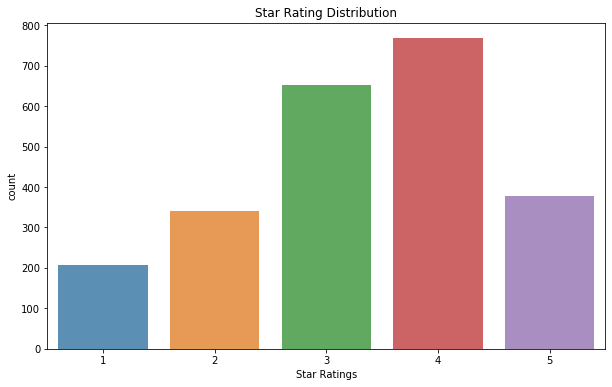

In [8]:
x=df['Star_Rating'].value_counts()
x=x.sort_index()
plt.figure(figsize=(10,6))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Star Rating Distribution")
plt.ylabel('count')
plt.xlabel('Star Ratings')
rects = ax.patches
labels = x.values
# for rect, label in zip(rects, labels):
#     height = rect.get_height()
#     ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
    
plt.savefig('rating_distr.jpg')
plt.show();

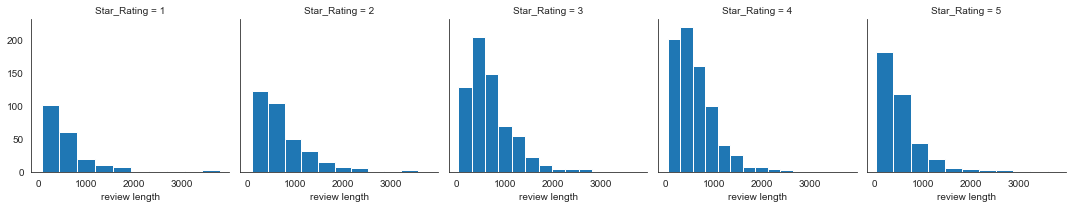

In [9]:
sns.set_style('white')
g = sns.FacetGrid(df,col='Star_Rating')
g.map(plt.hist,'review length')
plt.savefig('review_length.jpg')
plt.show()

## Cleaning Text Data

In [10]:
import re
import string

#function to clean text
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\!]', '', text) # remove characters in brackets
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) #remove punctuation
    text = re.sub('\w*\d\w*', '', text) # remove digits between letters or words
    text = re.sub('\n', '', text) # remove break lines
    text = re.sub('0123456789','',text) # remove digits
    return text

cleantext = lambda x: clean_text(x)

In [11]:
df.head()

,Date,Star_Rating,Review,Year,review length
0,10/17/2019,5,This place has been around for years! I rememb...,2019-10-17,267
1,2/4/2020,3,This place is just okay. The layout of the sho...,2020-02-04,695
2,1/28/2020,3,I went here for the first time and got a D3 (c...,2020-01-28,427
3,1/1/2020,1,Okay in another world I would be giving a 5 st...,2020-01-01,896
4,2/24/2020,5,I loved their passion fruit green tea with coc...,2020-02-24,183


In [12]:
#cleaning the text using clean_text function
df_cleaning = pd.DataFrame(df.Review.apply(cleantext))

In [13]:
df_cleaning.head()

,Review
0,this place has been around for years i remembe...
1,this place is just okay the layout of the shop...
2,i went here for the first time and got a cara...
3,okay in another world i would be giving a sta...
4,i loved their passion fruit green tea with coc...


In [109]:
#function to only keep Noun and Adjective in text
def nouns_adj(text):
    '''Given a string of text, tokenize the text and pull out only the nouns and adjectives.'''
    is_noun_adj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ'
    tokenized = word_tokenize(text)
    nouns_adj = [word for (word, pos) in pos_tag(tokenized) if is_noun_adj(pos)] 
    return ' '.join(nouns_adj)

In [113]:
#Keep only Noun and Adjectives in Reviews
data_clean = pd.DataFrame(df_cleaning.Review.apply(nouns_adj))

In [14]:
#tokenzie and lemmatize
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

In [15]:
data_clean['lem'] = data_clean['Review'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [ ]:
#pickel for later
data_clean.to_pickle('data_clean.pkl')

## Wordcloud for most frequent words

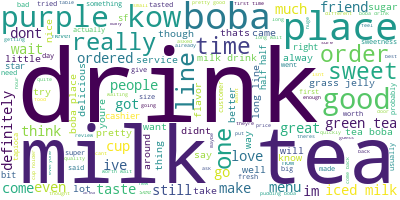

In [104]:
long_string = ','.join(list(data_clean['Review'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=500, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

There are some frequent words like 'drink', 'purple', 'kow', 'really', 'place' that will not add a

## StopWords

In [17]:
stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ['purple','kow','drink','people','purple kow','place','wa','half','socal',
                'norcal','something','menu','grass','time','make','even','another','order',
               'sf','friend','back','get','got','came','come','went','go','sweet','jelly']
stopwords.extend(newStopWords)

## Count Vectorizer

In [18]:
cv = CountVectorizer(stop_words=stopwords, ngram_range=(1,2), max_df = 0.8, min_df=3)
data_cv = cv.fit_transform(data_clean.lem)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
pickle.dump(cv,open("cv_stop.pkl",'wb')) 
data_dtm.to_pickle('dtm_stop.pkl')

## TF-IDF Vectorizer

In [19]:
tfidf2 = TfidfVectorizer(ngram_range=(1,2), binary=True, stop_words=stopwords, max_df = 0.8, min_df=3)
data_tfidf2 = tfidf2.fit_transform(data_clean.lem)

## Topic Modeling (LSA, NMF)

In [20]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

## LSA with TFIDF vectorizer

In [21]:
lsa = TruncatedSVD(7) # set number of topics. here it's 2
doc_topic = lsa.fit_transform(data_tfidf2)
lsa.explained_variance_ratio_

array([0.00187112, 0.00431342, 0.00380974, 0.00352042, 0.00327371,
       0.00306135, 0.00251781])

In [22]:
topic_word = pd.DataFrame(lsa.components_.round(3),
             index = ["component_1","component_2",'component_3','c4','c5','c6','c7'],
             columns = tfidf2.get_feature_names())

In [23]:
display_topics(lsa, tfidf2.get_feature_names(), 7)


Topic  0
tea, milk, boba, line, milk tea, wait, good

Topic  1
pudding, favorite, boba, milk, iced, iced milk, love

Topic  2
cup, fit, holder, cup holder, car, green, fit cup

Topic  3
long, worth, cup, wait, fit, holder, cup holder

Topic  4
iced, pudding, iced milk, pudding boba, caramel, fit, cup holder

Topic  5
chicken, popcorn, popcorn chicken, holder, fit, cup holder, pepper

Topic  6
service, customer, favorite, customer service, always, fit, holder


## LSA with count vectorizer

In [29]:
lsa = TruncatedSVD(7) # set number of topics. here it's 2
doc_topic_cv = lsa.fit_transform(data_cv)
lsa.explained_variance_ratio_

array([0.08963864, 0.03305697, 0.02340556, 0.01826   , 0.01339197,
       0.01141474, 0.00981733])

In [30]:
topic_word_cv = pd.DataFrame(lsa.components_.round(3),
             index = ["component_1","component_2",'component_3','c4','c5','c6','c7'],
             columns = cv.get_feature_names())

In [31]:
display_topics(lsa,  cv.get_feature_names(), 7)


Topic  0
tea, milk, boba, milk tea, like, line, wait

Topic  1
tea, milk tea, milk, green, green tea, matcha, green milk

Topic  2
wait, line, minute, long, tapioca, dont, waiting

Topic  3
tea, green, green tea, boba, fresh, like, fruit

Topic  4
like, iced, really, iced milk, good, chicken, taste

Topic  5
cup, fit, holder, cup holder, car, tapioca, minute

Topic  6
like, milk tea, line, boba, didnt, ordered, dont


**Topics somewhat make sense with LSA,Tf-idf vectorzier.**

## NMF with Count vectorizer

In [32]:
nmf_cv = TruncatedSVD(7) # set number of topics
doc_topic_cv = nmf_cv.fit_transform(data_cv)
nmf_cv.explained_variance_ratio_

array([0.08963864, 0.03305695, 0.02340548, 0.01826002, 0.01339042,
       0.01141663, 0.00980769])

In [33]:
topic_word_cv = pd.DataFrame(nmf_cv.components_.round(3),
             index = ["component_1","component_2",'component_3','component_4',
                     'component_5','component_6','component_7'],
             columns = cv.get_feature_names())

In [34]:
display_topics(nmf_cv,  cv.get_feature_names(), 7)


Topic  0
tea, milk, boba, milk tea, like, line, wait

Topic  1
tea, milk tea, milk, green, green tea, matcha, green milk

Topic  2
wait, line, minute, long, tapioca, dont, waiting

Topic  3
tea, green, green tea, boba, fresh, like, fruit

Topic  4
like, iced, iced milk, really, chicken, good, taste

Topic  5
cup, fit, holder, cup holder, car, tapioca, minute

Topic  6
like, milk tea, boba, line, ordered, didnt, cashier


**NMF count vectorizer: Most topics make sense.  But there are multiple topics talking just about tea and drink.**

## NMF with TFIDF vectorizer

In [35]:
nmf_model = NMF(7)
doc_topic1 = nmf_model.fit_transform(data_tfidf2)

In [36]:
topic_word1 = pd.DataFrame(nmf_model.components_.round(2),
             index = ["component_1","component_2","component_3","component_4",
                      'component_5','component_6','component_7'],
             columns = tfidf2.get_feature_names())

In [37]:
display_topics(nmf_model, tfidf2.get_feature_names(),7)


Topic  0
minute, waiting, dont, wait, around, waited, took

Topic  1
tea, green, milk tea, green tea, milk, tea boba, matcha

Topic  2
long, line, worth, wait, long line, worth wait, line long

Topic  3
fit, holder, cup holder, cup, car, fit cup, dont fit

Topic  4
pudding, iced, iced milk, pudding boba, caramel, boba, milk

Topic  5
chicken, popcorn, popcorn chicken, pepper, salt, salt pepper, fry

Topic  6
service, customer, customer service, asked, cashier, slow, rude


#### With TF-IDF vectorizer, the topis are more unique and each topic's top words are more relevant compared to each other.  So we will use NMF with **TF-IDF vectorizer** for topic modeling.

In [116]:
topic_weight = pd.DataFrame(doc_topic1.round(5),
             index = df.Review,
             columns = ["WaitTime","Tea",'Queue','CupSize','IcedMilk','Food','Service'])
topic_weight.head()

,WaitTime,Tea,Queue,CupSize,IcedMilk,Food,Service
Review,,,,,,,
This place has been around for years! I remember when they first opened when I was in high school. The boba is delicious with multiple different options hehe. The name is pretty captivating and sure is an attention grabber. I'm glad this is only 4 blocks away from me,0.05163,0.00236,0.00000,0.00000,0.01685,0.00645,0.00000
"This place is just okay. The layout of the shop is inconvenient because a line of 6 people already reaches out the door, and the area is narrow so it's not the greatest when you have people coming in and out. And they take anywhere from 5-20 minutes to make your drink. I come here if I absolutely crave boba but it's not that great. The last time I came here I got hazelnut milktea with chocolate pudding, but it tasted like a Tootsie roll. WtfThe matcha drinks are pretty good but they take a while to make. And as a tip, the drinks have perforated holes for the paper straws to go through so you don't have to keep stabbing the top with the straw hoping that it'll pierce through the plastic.",0.03644,0.01641,0.00831,0.00633,0.02607,0.00514,0.00168
I went here for the first time and got a D3 (caramel milk drink with pudding and boba). The place was packed with a bunch of high schoolers but the drinks came out fast. The lady at the register was pretty rude to the customers (she was nice to me though). The drink was good but it was too sweet for me. If I were to come back I would get the same thing but get it less sweet. This place isn't my go to boba shop in SF though.,0.01472,0.00000,0.00000,0.00000,0.10006,0.00000,0.05878
"Okay in another world I would be giving a 5 star review bc I love this place but uhh yesterday I bought a good ol' D3 50% sweet (caramel milk drink with pudding and boba) for my mom and there was a chunk of styrofoam or something in it?????? Actually there were multiple chunks but she said she accidentally swallowed the smaller pieces LOL RIP Honestly imma still go back tho.. the pudding is too good but ya when she told me, I was shocked since this has never happened before and I was like what's the protocol?? Do I call purple cow and be like ""hello my mom did a little chokey chokey cuz u put plastic in our drink ahaaaaa can I get a refund?"" In the end I'm just writing this yelp review so do with this information what you will. No fatalities though so I'll still frequent this place bc that's who I am as a person and my parents are whatever about it and it's still their fave boba shop",0.03478,0.00000,0.00000,0.00304,0.07113,0.00381,0.02517
I loved their passion fruit green tea with coconut jelly and boba!! Perfect combo! I asked for 50% sweet and good thing I did because it was still sweet but just how I usually get it!,0.00000,0.09434,0.00049,0.00000,0.00524,0.00492,0.02056


In [40]:
topic_weight = topic_weight.reset_index()

In [41]:
#add star rating and year column to topic_weight dataframe
topic_df = pd.concat([topic_weight,df['Star_Rating'],df['Year']],axis = 1)

In [43]:
#Find the most dominant topic for each review based on their weight.
topic_df['Dominant_Topic']=topic_df[['WaitTime','IcedMilk','Queue','Tea','Service','CupSize','Food']].idxmax(axis=1)

In [45]:
#create new column called sentiment based on the star rating
topic_df['Sentiment']=topic_df['Star_Rating']

In [46]:
#bin the star rating into sentiment values (categorical).  5-4 is positive, 3 is neutral, 1-2 is negative
topic_df['Sentiment'].replace([5], 'Positive', inplace = True)
topic_df['Sentiment'].replace([4], 'Positive', inplace = True)
topic_df['Sentiment'].replace([3], 'Neutral', inplace = True)
topic_df['Sentiment'].replace([2], 'Negative', inplace = True)
topic_df['Sentiment'].replace([1], 'Negative', inplace = True)

In [47]:
topic_df.head()

,Review,WaitTime,Tea,Queue,CupSize,IcedMilk,Food,Service,Star_Rating,Year,Dominant_Topic,Sentiment
0,This place has been around for years! I rememb...,0.05163,0.00236,0.00000,0.00000,0.01685,0.00645,0.00000,5,2019-10-17,WaitTime,Positive
1,This place is just okay. The layout of the sho...,0.03644,0.01641,0.00831,0.00633,0.02607,0.00514,0.00168,3,2020-02-04,WaitTime,Neutral
2,I went here for the first time and got a D3 (c...,0.01472,0.00000,0.00000,0.00000,0.10006,0.00000,0.05878,3,2020-01-28,IcedMilk,Neutral
3,Okay in another world I would be giving a 5 st...,0.03478,0.00000,0.00000,0.00304,0.07113,0.00381,0.02517,1,2020-01-01,IcedMilk,Negative
4,I loved their passion fruit green tea with coc...,0.00000,0.09434,0.00049,0.00000,0.00524,0.00492,0.02056,5,2020-02-24,Tea,Positive


In [54]:
topic_sentiment_count = pd.DataFrame(topic_df.groupby('Dominant_Topic')['Sentiment'].value_counts())

In [55]:
topic_sentiment_count.rename(columns={'Sentiment':'count'},inplace=True)

In [56]:
topic_sentiment_count

count
Dominant_Topic Sentiment       
CupSize        Neutral       81
               Positive      69
               Negative      27
Food           Positive     147
               Neutral       35
               Negative      16
IcedMilk       Positive     236
               Neutral       71
               Negative      31
Queue          Positive     185
               Neutral      106
               Negative      79
Service        Negative     116
               Positive      46
               Neutral       32
Tea            Positive     288
               Neutral      139
               Negative      78
WaitTime       Negative     201
               Neutral      189
               Positive     175

In [57]:
topic_sentiment_count.reset_index(inplace=True)

In [62]:
topic_df.groupby('Dominant_Topic')['Sentiment'].count()

Dominant_Topic
CupSize     177
Food        198
IcedMilk    338
Queue       370
Service     194
Tea         505
WaitTime    565
Name: Sentiment, dtype: int64

In [119]:
topic_df.groupby('Sentiment')['Star_Rating'].count()

Sentiment
Negative     548
Neutral      653
Positive    1146
Name: Star_Rating, dtype: int64

In [145]:
topic_df.to_pickle('topic_data.pkl')

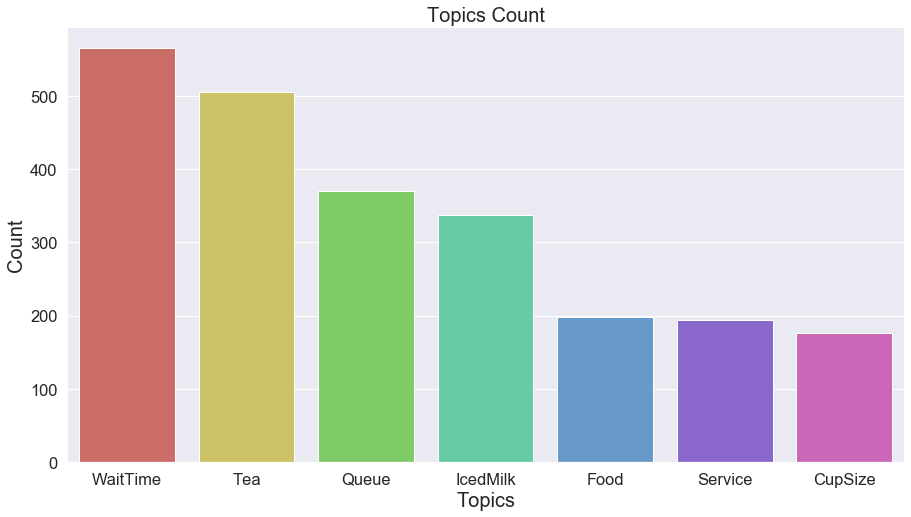

In [59]:
#bar plot for topic distribution
plt.figure(figsize=(15,8))
sns.set(font_scale = 1.5)
sns.countplot(x='Dominant_Topic', data = topic_df, palette='hls', 
              order = topic_df['Dominant_Topic'].value_counts().index);
plt.xlabel('Topics', size=20)
plt.ylabel('Count', size = 20)
plt.title('Topics Count', size = 20)
plt.savefig('topic_hist.jpg')
plt.show()

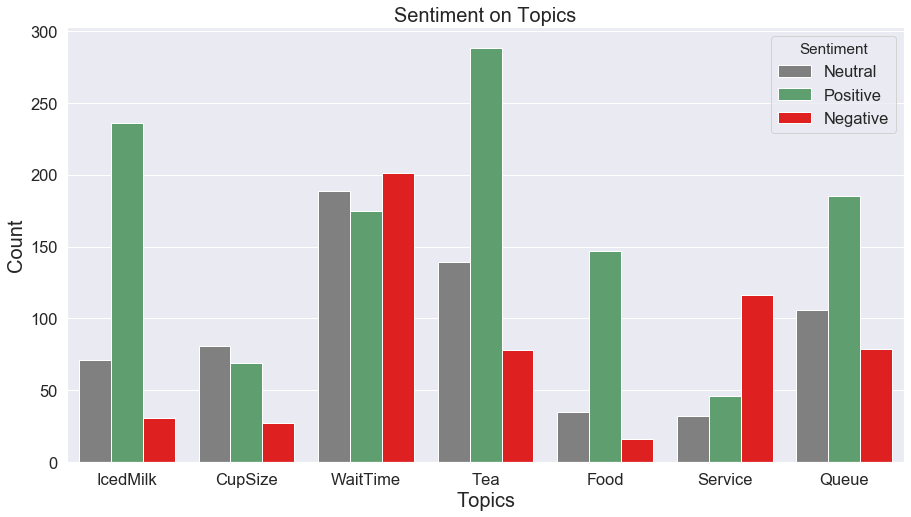

In [146]:
#bar plot for sentiment on each topic
plt.figure(figsize=(15,8))
sns.barplot(x='Dominant_Topic', y='count', hue='Sentiment', data=topic_sentiment_count,palette=['Gray', "C2", "Red"],
           order = topic_sentiment_count['Dominant_Topic'].value_counts().index)

plt.xlabel('Topics', size=20)
plt.ylabel('Count', size = 20)
plt.title('Sentiment on Topics', size = 20)
plt.savefig('topic_sentiment.jpg')
plt.show()

#### The following codes are only for exploratory purposes and the results are not used in this project.

## TFIDF Bigram vectorizer

In [75]:
tfidfbi = TfidfVectorizer(ngram_range=(2,2), stop_words = stopwords)
data_tfidfbi = tfidfbi.fit_transform(data_clean.lem)

In [76]:
nmf_model_bi = NMF(7)
doc_topicbi = nmf_model_bi.fit_transform(data_tfidfbi)

In [77]:
topic_word_bi = pd.DataFrame(nmf_model_bi.components_.round(2),
             index = ["component_1","component_2","component_3","component_4",
                      "component_5","component_6","component_7"],
             columns = tfidfbi.get_feature_names())

In [78]:
display_topics(nmf_model_bi, tfidfbi.get_feature_names(), 7)


Topic  0
milk tea, tea boba, green milk, oolong milk, black milk, honey milk, regular milk

Topic  1
iced milk, pudding boba, milk caramel, caramel pudding, milk pudding, boba pudding, milk boba

Topic  2
green tea, milk green, tea boba, matcha milk, peach green, mango green, matcha green

Topic  3
long line, worth wait, long wait, line long, wait line, always long, wait long

Topic  4
ice milk, milk boba, love ice, boba glass, milk pudding, like ice, boba pudding

Topic  5
cup holder, fit cup, dont fit, car cup, doesnt fit, fit car, cup dont

Topic  6
bubble tea, best bubble, tea ever, line long, really really, tea ive, tea although


TF-IDF with bigram: the topics make sense but again there are multiple topics just talking about tea and drinks.

## Exploring Sentiment Analysis using TextBlob

In [80]:
from textblob import TextBlob

In [81]:
pol = lambda x:TextBlob(x).sentiment.polarity
sub = lambda x:TextBlob(x).sentiment.subjectivity

In [82]:
df['polarity'] = df['Review'].apply(pol)
df['subjectivity']=df['Review'].apply(sub)

In [83]:
df.head()

,Date,Star_Rating,Review,Year,review length,polarity,subjectivity
0,10/17/2019,5,This place has been around for years! I rememb...,2019-10-17,267,0.316000,0.736222
1,2/4/2020,3,This place is just okay. The layout of the sho...,2020-02-04,695,0.231818,0.683333
2,1/28/2020,3,I went here for the first time and got a D3 (c...,2020-01-28,427,0.199444,0.513750
3,1/1/2020,1,Okay in another world I would be giving a 5 st...,2020-01-01,896,0.215278,0.461111
4,2/24/2020,5,I loved their passion fruit green tea with coc...,2020-02-24,183,0.353571,0.607143


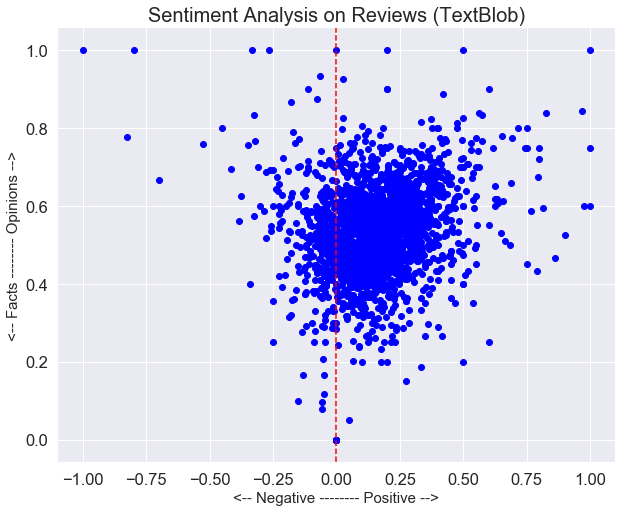

In [100]:
plt.rcParams['figure.figsize'] = [10, 8]

for index, Review in enumerate(df.index):
    x = df.polarity.loc[Review]
    y = df.subjectivity.loc[Review]
    plt.scatter(x, y, color='blue')
    plt.xlim(-1.1, 1.1) 
    
plt.title('Sentiment Analysis on Reviews (TextBlob)', fontsize=20)
plt.axvline(x=0, color = 'red', linestyle = '--')
plt.xlabel('<-- Negative -------- Positive -->', fontsize=15)
plt.ylabel('<-- Facts -------- Opinions -->', fontsize=15)
plt.savefig('textblob_sentiment.jpg')
plt.show()

**According to TextBlob, there are way more positive reviews than negative and it does not agree with the actual star rating of the reviews.**